In [ ]:
import pickle
import numpy as np
import os
from keras.callbacks import LearningRateScheduler,EarlyStopping
from keras.layers import Dense,LSTM,Flatten
from keras.regularizers import l2
from scipy.interpolate import splev, splrep
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from keras.layers import GRU


In [ ]:
base_dir="/content/drive/MyDrive/dataset/osa_data"

In [ ]:
# DEEP LEARNING MODELS NEED TO VECTORS OR MATRIX WITH SAME SIZE
# R-R INTERVALS DONT HAVE SAME SIZE, SO WE NEED TO INTERPOLATE VECTORS TO GET VECTORS WITH SAME SIZE.
# BASED ON OUR EXPERIENCE INTERPOLATION IN 3 HZ BETTER AND ACCURATE.
ir = 3 # INTERPOLATION RATE(3HZ)
time_range= 60 # 60-s INTERVALS OF ECG SIGNALS
weight=1e-3 #  WEIGHT L2 FOR REGULARIZATION(AVODING OVERFITTING PARAMETER)
#------------------------------------------------------------------------------
# NORMALIZATION:
# DEEP LEARNING AND EVEN NEURAL NETWORKS INPUT SHOULD BE NORMALIZED:
# MIN-MAX METHOD APPLIED FOR SCALING:(Array-min(Array))/(max(Array)-min(Array))
scaler = lambda arr: (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [ ]:
# IN PRE-PROCESSING SECTION WE EXTRACT R-R INTERVALS AND R-PEAK AMPLITUDES
# IN THIS PART WE LOAD THIS DATA AND INTERPOLATE AND CONCATE FOR FEEDING TO NETWORKS
def load_data():
    tm = np.arange(0, (time_range), step=(1) / float(ir)) # TIME METRIC FOR INTERPOLATION
    # LOAD AND INTERPOLATE R-R INTERVALS AND R-PEAK AMPLITUDES
    with open(os.path.join( base_dir,"apnea-ecg.pkl"), 'rb') as f:
        apnea_ecg = pickle.load(f)

    x = []
    X, Y = apnea_ecg["o_train"], apnea_ecg["y_train"]
    for i in range(len(X)):
        (rri_tm, rri_signal), (amp_tm, amp_signal) = X[i]
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        amp_interp_signal = splev(tm, splrep(amp_tm, scaler(amp_signal), k=3), ext=1)
        x.append([rri_interp_signal, amp_interp_signal])
    x = np.array(x, dtype="float32")


    x = np.expand_dims(x,1)
    x_final=np.array(x, dtype="float32").transpose((0,3,2,1))


    return x_final, Y

In [ ]:
# CREAT DEEP LEARNING MODEL
gru = tf.keras.layers.GRU(4)
def create_model():
    model=Sequential()
    model.add(GRU(60, return_sequences=True, input_shape=(2,180)))
    model.add(GRU(20, return_sequences=True))
    model.add(GRU(13, return_sequences=True))

    model.add(Flatten())
    model.add(Dense(4, activation="relu"))
    model.add(Dense(2, activation="softmax"))

    return model
#------------------

In [ ]:
def lr_schedule(epoch, lr):
    if epoch > 70 and \
            (epoch - 1) % 10 == 0:
        lr *= 0.1
    print("Learning rate: ", lr)
    return lr

In [ ]:
if __name__ == "__main__":
    # loading Data:
    X, Y = load_data()
    # we have labels(Y) in a binary way 0 for normal and 1 for apnea patients
    # we want to classify data into 2-class so we changed y in a categorical way:
    Y = tf.keras.utils.to_categorical(Y, num_classes=2)
    # we used k-fold cross-validation for more reliable experiments:
    kfold = StratifiedKFold(n_splits=5, shuffle=True,random_state=7)
    cvscores = []
    ACC=[]
    SN=[]
    SP=[]
    F2=[]
    X= np.reshape(X,(X.shape[0],90,2,2))
    X= np.concatenate((X[:,:90,:,0],X[:,:90,:,1]),axis=1)
    X= X.transpose((0,2,1))
    for train, test in kfold.split(X, Y.argmax(1)):
     model = create_model()


     model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
     lr_scheduler = LearningRateScheduler(lr_schedule)

     callback1 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

     X1,x_val,Y1,y_val=train_test_split(X[train],Y[train],test_size=0.10)

     history = model.fit(X1, Y1, batch_size=128, epochs=100, validation_data=(x_val, y_val),
                        callbacks=[callback1,lr_scheduler])
     model.save(os.path.join("model.LSTM.h5"))

Learning rate:  0.0010000000474974513
Epoch 1/100
94/94 [==============================] - 10s 27ms/step - loss: 0.6432 - accuracy: 0.6160 - val_loss: 0.6303 - val_accuracy: 0.6230 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 2/100
94/94 [==============================] - 1s 15ms/step - loss: 0.6082 - accuracy: 0.6755 - val_loss: 0.6013 - val_accuracy: 0.7061 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 3/100
94/94 [==============================] - 1s 13ms/step - loss: 0.5810 - accuracy: 0.7111 - val_loss: 0.5785 - val_accuracy: 0.7300 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 4/100
94/94 [==============================] - 1s 12ms/step - loss: 0.5648 - accuracy: 0.7257 - val_loss: 0.5792 - val_accuracy: 0.7285 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 5/100
94/94 [==============================] - 1s 12ms/step - loss: 0.5546 - accuracy: 0.7366 - val_loss: 0.5444 - val_accuracy: 0.7487 - lr: 0.0010
Learning rate:  0.0010000000474974

42/42 [==============================] - 0s 5ms/step - loss: 0.4420 - accuracy: 0.8025
Test loss:  0.4419592320919037
Accuracy:  0.8025429844856262
42/42 [==============================] - 1s 2ms/step


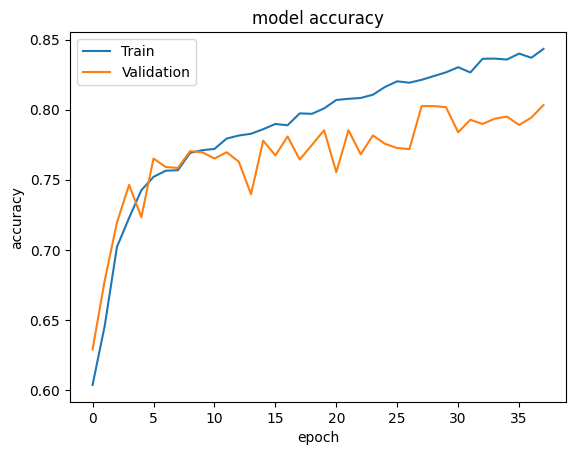

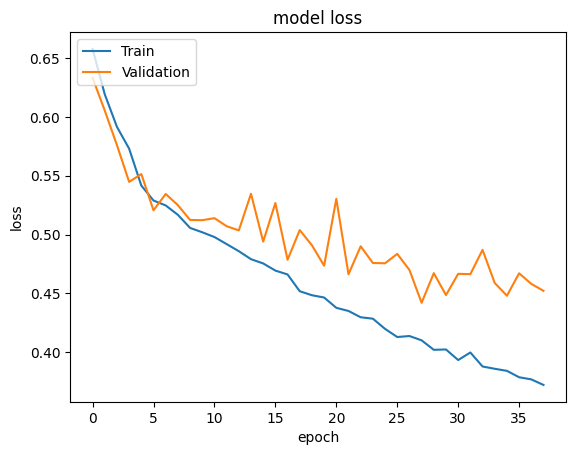

In [ ]:

    loss, accuracy = model.evaluate(x_val, y_val) # test the model
    print("Test loss: ", loss)
    print("Accuracy: ", accuracy)

    # save prediction score
    y_score = model.predict(x_val)
    #output = pd.DataFrame({"y_true": y_test[:, 1], "y_score": y_score[:, 1], "subject": groups_test})
    #output.to_csv(os.path.join("base_dir", "LeNet.csv"), index=False)
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()